In [1]:
from camelyon.datasets import RankNetInductionDataset

dataset = RankNetInductionDataset(
    root_dir="/vast/AI_team/dataset/CAMELYON16/feature/resnet50_3rd_20x_h5/test",
    slide_dir="/vast/AI_team/dataset/CAMELYON16/slide/test",
    annotation_dir="/vast/AI_team/dataset/CAMELYON16/annotations",
    mpp=0.5,
    tile_size=224,
)

/home/heon/anaconda3/envs/camelyon/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import mlflow
import torch
from camelyon.log_ops import TRACKING_URI
mlflow.set_tracking_uri(TRACKING_URI)

base_model = mlflow.pytorch.load_model(
    "file:///vast/AI_team/mlflow_artifact/25/34322e35a0844d0780dabd53fa059499/artifacts/model"
).eval().to("cuda")
att_model = mlflow.pytorch.load_model(
    "file:///vast/AI_team/mlflow_artifact/25/57b3c264b1f743fa9072f8d7d5782f14/artifacts/model"
).eval().to("cuda")
ltr_model = mlflow.pytorch.load_model(
    "file:///vast/AI_team/mlflow_artifact/25/47eaa4f5f1194779a48c96dde2793353/artifacts/model"
).eval().to("cuda")

In [4]:
base_model.return_with

'contribution'

In [61]:
import torch

base_model.threshold = False
base_model.return_with = "attention_score"
att_model.return_with = "attention_score"
ltr_model.return_with = "attention_score"
IDX = 15
features, bag_label, patch_labels = dataset[IDX]
print("bag_label", bag_label)
with torch.no_grad():
    base_logit, base_attention_weights = base_model(features)
    print(base_logit)
    att_logit, att_attention_weights = att_model(features)
    print(att_logit)
    ltr_logit, ltr_attention_weights = ltr_model(features)
    print(ltr_logit)
    
print(dataset.bag_h5_paths[IDX])

bag_label tensor([1.], device='cuda:0')
tensor([5.0236], device='cuda:0')
tensor([5.1357], device='cuda:0')
tensor([4.4580], device='cuda:0')
/vast/AI_team/dataset/CAMELYON16/feature/resnet50_3rd_20x_h5/test/M/test_040.h5


/vast/AI_team/dataset/CAMELYON16/slide/test/M/test_040.tif


Text(0.5, 1.0, 'Rank induction \n(P=0.989)')

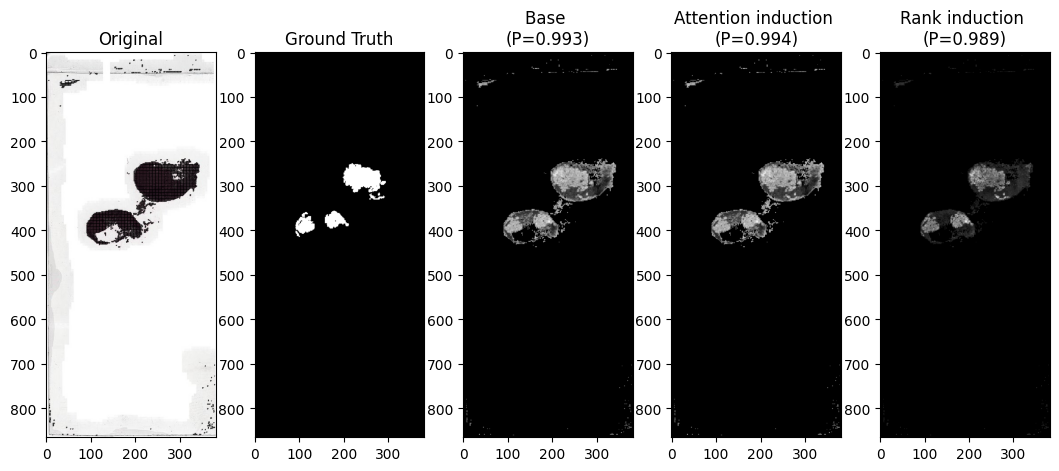

<Figure size 3000x2000 with 0 Axes>

In [62]:
import os
import seaborn as sns
import numpy as np
from openslide import OpenSlide
from openslide.deepzoom import DeepZoomGenerator
from camelyon.misc import get_deepzoom_level
from camelyon.data_models import Patches
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(13, 5))

MPP = 0.5
LINE_WIDTH = 1
DOWNSAMPLE_RATE = 256

x, y, patch_labels = dataset[IDX]
slide_path = dataset.bag_h5_paths[IDX].replace("/vast/AI_team/dataset/CAMELYON16/feature/resnet50_3rd_20x_h5", "/vast/AI_team/dataset/CAMELYON16/slide").replace("h5", "tif")
print(slide_path)
osr = OpenSlide(slide_path)
dgz = DeepZoomGenerator(osr, overlap=0, tile_size=224, limit_bounds=True)
w, h = osr.dimensions

# get_thumbnail() 호출 시에도 (width, height) 순으로
thumbnail_img = osr.get_thumbnail((w // DOWNSAMPLE_RATE, h // DOWNSAMPLE_RATE))
thumbnail = np.array(thumbnail_img)
thumbnail_heatmap = np.zeros_like(thumbnail, dtype=np.float32)

patches = Patches.from_feature_h5(dataset.bag_h5_paths[IDX])
deepzoom_level = get_deepzoom_level(desired_mpp=MPP, slide=osr)

pred_base_heatmap = np.zeros_like(thumbnail, dtype=np.float32)
base_attention_weights = base_attention_weights.cpu().numpy()
norm_base_attention_weights = (base_attention_weights - base_attention_weights.min()) / (base_attention_weights.max() - base_attention_weights .min())

pred_att_heatmap = np.zeros_like(thumbnail, dtype=np.float32)
att_attention_weights = att_attention_weights.cpu().numpy()
norm_att_attention_weights = (att_attention_weights - att_attention_weights.min()) / (att_attention_weights.max() - att_attention_weights.min())

pred_ltr_heatmap = np.zeros_like(thumbnail, dtype=np.float32)
ltr_attention_weights = ltr_attention_weights.cpu().numpy()
norm_ltr_attention_weights = (ltr_attention_weights - ltr_attention_weights.min()) / (ltr_attention_weights.max() - ltr_attention_weights.min())

for i, (patch, patch_label, base_attention_weight, att_attention_weight, ltr_attention_weight) in \
    enumerate(zip(patches, patch_labels, norm_base_attention_weights, norm_att_attention_weights, norm_ltr_attention_weights)):
    location, slide_level, size = dgz.get_tile_coordinates(deepzoom_level, patch.address)
    
    x, y = location # at level 0 
    w, h = size
    base_tile_w = w * osr.level_downsamples[slide_level]
    base_tile_h = h * osr.level_downsamples[slide_level]
    
    # 썸네일(1/128) 좌표로 변환
    thumb_x_min = int(x / DOWNSAMPLE_RATE)
    thumb_y_min = int(y / DOWNSAMPLE_RATE)
    thumb_x_max = int((x + base_tile_w) / DOWNSAMPLE_RATE)
    thumb_y_max = int((y + base_tile_h) / DOWNSAMPLE_RATE)
    
    thumbnail_heatmap[thumb_y_min:thumb_y_max, thumb_x_min:thumb_x_max] = patch_label.item()
    
    # 사각형 박스 그리기
    thumbnail[thumb_y_min:thumb_y_max, thumb_x_min:thumb_x_min+LINE_WIDTH, :] = [0, 0, 0]   # 왼쪽
    thumbnail[thumb_y_min:thumb_y_max, thumb_x_max:thumb_x_max+LINE_WIDTH, :] = [0, 0, 0]  # 오른쪽
    thumbnail[thumb_y_min:thumb_y_min+LINE_WIDTH, thumb_x_min:thumb_x_max, :] = [0, 0, 0]  # 위
    thumbnail[thumb_y_max:thumb_y_max+LINE_WIDTH, thumb_x_min:thumb_x_max, :] = [0, 0, 0]  # 아래
    
    # prediction
    pred_base_heatmap[thumb_y_min:thumb_y_max, thumb_x_min:thumb_x_max] = base_attention_weight.item()
    pred_att_heatmap[thumb_y_min:thumb_y_max, thumb_x_min:thumb_x_max] = att_attention_weight.item()
    pred_ltr_heatmap[thumb_y_min:thumb_y_max, thumb_x_min:thumb_x_max] = ltr_attention_weight.item()
    
    
plt.figure(figsize=(30, 20))
axes[0].imshow(thumbnail)
axes[1].imshow(thumbnail_heatmap*255, vmin=0, vmax=dataset.patch_labels[IDX].max())
axes[2].imshow(pred_base_heatmap, vmin=0, vmax=1)
axes[3].imshow(pred_att_heatmap, vmin=0, vmax=1)
axes[4].imshow(pred_ltr_heatmap, vmin=0, vmax=1)

axes[0].set_title("Original")
axes[1].set_title("Ground Truth")
axes[2].set_title(f"Base \n(P={round(torch.sigmoid(base_logit).cpu().item(), 3)})")
axes[3].set_title(f"Attention induction \n(P={round(torch.sigmoid(att_logit).cpu().item(), 3)})")
axes[4].set_title(f"Rank induction \n(P={round(torch.sigmoid(ltr_logit).cpu().item(), 3)})")


/vast/AI_team/dataset/CAMELYON16/slide/test/M/test_040.tif


Text(0.5, 1.0, 'Rank induction \n(P=0.989)')

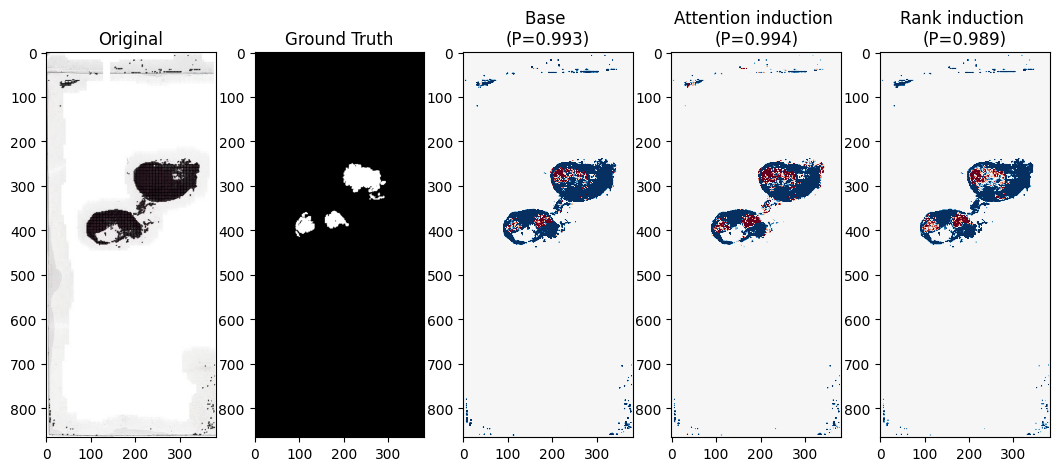

<Figure size 3000x2000 with 0 Axes>

In [63]:
import os
import seaborn as sns
import numpy as np
from openslide import OpenSlide
from openslide.deepzoom import DeepZoomGenerator
from camelyon.misc import get_deepzoom_level
from camelyon.data_models import Patches
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(13, 5))

MPP = 0.5
LINE_WIDTH = 1
DOWNSAMPLE_RATE = 256

x, y, patch_labels = dataset[IDX]
slide_path = dataset.bag_h5_paths[IDX].replace("/vast/AI_team/dataset/CAMELYON16/feature/resnet50_3rd_20x_h5", "/vast/AI_team/dataset/CAMELYON16/slide").replace("h5", "tif")
print(slide_path)
osr = OpenSlide(slide_path)
dgz = DeepZoomGenerator(osr, overlap=0, tile_size=224, limit_bounds=True)
w, h = osr.dimensions

# get_thumbnail() 호출 시에도 (width, height) 순으로
thumbnail_img = osr.get_thumbnail((w // DOWNSAMPLE_RATE, h // DOWNSAMPLE_RATE))
thumbnail = np.array(thumbnail_img)
thumbnail_heatmap = np.zeros_like(thumbnail, dtype=np.float32)

patches = Patches.from_feature_h5(dataset.bag_h5_paths[IDX])
deepzoom_level = get_deepzoom_level(desired_mpp=MPP, slide=osr)

pred_base_heatmap = np.zeros_like(thumbnail[:,:,0], dtype=np.float32)
base_attention_weights = base_attention_weights#.cpu().numpy()

pred_att_heatmap = np.zeros_like(thumbnail[:,:,0], dtype=np.float32)
att_attention_weights = att_attention_weights#.cpu().numpy()

pred_ltr_heatmap = np.zeros_like(thumbnail[:,:,0], dtype=np.float32)
ltr_attention_weights = ltr_attention_weights#.cpu().numpy()

for i, (patch, patch_label, base_attention_weight, att_attention_weight, ltr_attention_weight) in \
    enumerate(zip(patches, patch_labels, base_attention_weights, att_attention_weights, ltr_attention_weights)):
    location, slide_level, size = dgz.get_tile_coordinates(deepzoom_level, patch.address)
    
    x, y = location
    w, h = size
    base_tile_w = w * osr.level_downsamples[slide_level]
    base_tile_h = h * osr.level_downsamples[slide_level]
    
    thumb_x_min = int(x / DOWNSAMPLE_RATE)
    thumb_y_min = int(y / DOWNSAMPLE_RATE)
    thumb_x_max = int((x + base_tile_w) / DOWNSAMPLE_RATE)
    thumb_y_max = int((y + base_tile_h) / DOWNSAMPLE_RATE)
    
    thumbnail_heatmap[thumb_y_min:thumb_y_max, thumb_x_min:thumb_x_max] = patch_label.item()
    
    thumbnail[thumb_y_min:thumb_y_max, thumb_x_min:thumb_x_min+LINE_WIDTH, :] = [0, 0, 0]
    thumbnail[thumb_y_min:thumb_y_max, thumb_x_max:thumb_x_max+LINE_WIDTH, :] = [0, 0, 0]
    thumbnail[thumb_y_min:thumb_y_min+LINE_WIDTH, thumb_x_min:thumb_x_max, :] = [0, 0, 0]
    thumbnail[thumb_y_max:thumb_y_max+LINE_WIDTH, thumb_x_min:thumb_x_max, :] = [0, 0, 0]
    
    pred_base_heatmap[thumb_y_min:thumb_y_max, thumb_x_min:thumb_x_max] = base_attention_weight.item()
    pred_att_heatmap[thumb_y_min:thumb_y_max, thumb_x_min:thumb_x_max] = att_attention_weight.item()
    pred_ltr_heatmap[thumb_y_min:thumb_y_max, thumb_x_min:thumb_x_max] = ltr_attention_weight.item()

plt.figure(figsize=(30, 20))
axes[0].imshow(thumbnail)
axes[1].imshow(thumbnail_heatmap*255, vmin=0, vmax=dataset.patch_labels[IDX].max())
axes[2].imshow(pred_base_heatmap, cmap='RdBu_r', vmin=-1, vmax=1)
axes[3].imshow(pred_att_heatmap, cmap='RdBu_r', vmin=-1, vmax=1)
axes[4].imshow(pred_ltr_heatmap, cmap='RdBu_r', vmin=-1, vmax=1)

axes[0].set_title("Original")
axes[1].set_title("Ground Truth")
axes[2].set_title(f"Base \n(P={round(torch.sigmoid(base_logit).cpu().item(), 3)})")
axes[3].set_title(f"Attention induction \n(P={round(torch.sigmoid(att_logit).cpu().item(), 3)})")
axes[4].set_title(f"Rank induction \n(P={round(torch.sigmoid(ltr_logit).cpu().item(), 3)})")